In [ ]:
import numpy as np
import tensorflow as tf
from scipy.integrate import solve_ivp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import random

# System parameters
J_rot = 0.01  # Rotational inertia
L = 0.001     # Motor inductance
R = 0.1       # Motor resistance
K_Q = 0.01    # Motor torque constant
K_v = 0.01    # Motor speed constant
i_0 = 0.5     # No-load current

# Placeholder for your VLM model
def vlm_model(rpm, velocity, angle):
    # Replace with your actual VLM model call
    Q_aero = 0.1 * rpm * velocity * np.sin(angle)
    thrust = 0.2 * rpm * velocity * np.cos(angle)
    return Q_aero, thrust

# Dynamic system equations
def system_dynamics(t, state, pwm, velocity, angle):
    rpm, current = state
    voltage = pwm * 0.005  # Example conversion
    Q_aero, _ = vlm_model(rpm, velocity, angle)
    Q_m = (current - i_0) / K_Q
    v_m = rpm / K_v
    d_rpm = (Q_m - Q_aero) / J_rot
    d_current = (voltage - v_m - current * R) / L
    return [d_rpm, d_current]

# Generate dynamic simulation with changing conditions
def simulate_with_diverse_transients(duration=30.0, time_step=0.01, scenario="mixed"):
    """
    Generate simulation data with diverse transient events
    
    Parameters:
    -----------
    duration : float
        Duration of simulation in seconds
    time_step : float
        Time step for simulation
    scenario : str
        Type of transients to include:
        - "velocity_only": Only velocity changes
        - "angle_only": Only angle changes
        - "pwm_only": Only PWM changes
        - "mixed": Mix of all types (default)
        - "random": Randomized transients
    
    Returns:
    --------
    results : list
        List of dictionaries with simulation results
    """
    # Time points
    times = np.arange(0, duration, time_step)
    n_points = len(times)
    
    # Initialize arrays to store results
    results = []
    
    # Base conditions
    velocity_base = 10.0  # m/s
    angle_base = np.radians(5.0)  # radians
    pwm_base = 1500  # µs
    
    # Initialize conditions
    velocities = np.ones(n_points) * velocity_base
    angles = np.ones(n_points) * angle_base
    pwm_values = np.ones(n_points) * pwm_base
    
    # Create transient events based on scenario
    if scenario == "velocity_only":
        # Create multiple velocity changes at different points
        vel_changes = [
            (int(n_points * 0.1), int(n_points * 0.15), 15.0),  # (start, end, value)
            (int(n_points * 0.3), int(n_points * 0.32), 8.0),
            (int(n_points * 0.5), int(n_points * 0.55), 18.0),
            (int(n_points * 0.7), int(n_points * 0.72), 5.0),
            (int(n_points * 0.85), int(n_points * 0.95), 12.0)
        ]
        
        for start, end, value in vel_changes:
            velocities[start:end] = value
            
    elif scenario == "angle_only":
        # Create multiple angle changes at different points
        angle_changes = [
            (int(n_points * 0.1), int(n_points * 0.15), np.radians(10.0)),
            (int(n_points * 0.3), int(n_points * 0.35), np.radians(-5.0)),
            (int(n_points * 0.45), int(n_points * 0.5), np.radians(8.0)),
            (int(n_points * 0.65), int(n_points * 0.7), np.radians(-10.0)),
            (int(n_points * 0.85), int(n_points * 0.9), np.radians(12.0))
        ]
        
        for start, end, value in angle_changes:
            angles[start:end] = value
            
    elif scenario == "pwm_only":
        # Create multiple PWM changes at different points
        pwm_changes = [
            (int(n_points * 0.1), 1600),   # (position, value)
            (int(n_points * 0.3), 1400),
            (int(n_points * 0.5), 1700),
            (int(n_points * 0.7), 1300),
            (int(n_points * 0.9), 1800)
        ]
        
        for position, value in pwm_changes:
            pwm_values[position:] = value  # PWM changes persist
            
    elif scenario == "mixed":
        # Mix of velocity, angle and PWM changes
        # Wind gust 1
        gust_start = int(n_points * 0.1)
        gust_end = int(n_points * 0.15)
        velocities[gust_start:gust_end] = 15.0
        angles[gust_start:gust_end] = np.radians(10.0)
        
        # PWM change 1
        pwm_change = int(n_points * 0.25)
        pwm_values[pwm_change:int(n_points * 0.4)] = 1600
        
        # Angle only change
        angle_start = int(n_points * 0.35)
        angle_end = int(n_points * 0.4)
        angles[angle_start:angle_end] = np.radians(-8.0)
        
        # Velocity only change
        vel_start = int(n_points * 0.5)
        vel_end = int(n_points * 0.55)
        velocities[vel_start:vel_end] = 18.0
        
        # PWM change 2
        pwm_change2 = int(n_points * 0.65)
        pwm_values[pwm_change2:int(n_points * 0.8)] = 1700
        
        # Wind gust 2
        gust2_start = int(n_points * 0.85)
        gust2_end = int(n_points * 0.9)
        velocities[gust2_start:gust2_end] = 7.0
        angles[gust2_start:gust2_end] = np.radians(15.0)
        
    elif scenario == "random":
        # Generate random transient events including longer-lasting ones
        num_events = random.randint(8, 15)  # 8-15 random events
        
        # Ensure we have at least 2-3 longer events (lasting 2+ seconds)
        num_long_events = random.randint(2, 3)
        
        # First create the longer events (2+ seconds)
        for _ in range(num_long_events):
            # Random start position (avoiding the very end)
            start = random.randint(0, int(n_points * 0.7))
            
            # Long duration (7-15% of total time, which is ~2-4.5 seconds for a 30 second simulation)
            duration_pct = random.uniform(0.07, 0.15)
            end = min(start + int(n_points * duration_pct), n_points)
            
            # Randomly select event type (1=velocity, 2=angle, 3=PWM, 4=both vel & angle)
            event_type = random.randint(1, 4)
            
            if event_type in [1, 4]:  # Velocity change
                new_velocity = random.uniform(5.0, 20.0)  # Random between 5-20 m/s
                velocities[start:end] = new_velocity
                
            if event_type in [2, 4]:  # Angle change
                new_angle = np.radians(random.uniform(-15.0, 15.0))  # Random between -15 to 15 degrees
                angles[start:end] = new_angle
                
            if event_type == 3:  # PWM change
                new_pwm = random.randint(1200, 1800)  # Random between 1200-1800 μs
                # PWM changes might persist for longer or reset
                persist = random.choice([True, False])
                if persist:
                    pwm_values[start:] = new_pwm
                else:
                    pwm_values[start:end] = new_pwm
        
        # Then add the remaining shorter events
        for _ in range(num_events - num_long_events):
            # Random start position (avoiding the very end)
            start = random.randint(0, int(n_points * 0.9))
            
            # Random duration (1-7% of total time)
            duration_pct = random.uniform(0.01, 0.07)
            end = min(start + int(n_points * duration_pct), n_points)
            
            # Randomly select event type (1=velocity, 2=angle, 3=PWM, 4=both vel & angle)
            event_type = random.randint(1, 4)
            
            if event_type in [1, 4]:  # Velocity change
                new_velocity = random.uniform(5.0, 20.0)  # Random between 5-20 m/s
                velocities[start:end] = new_velocity
                
            if event_type in [2, 4]:  # Angle change
                new_angle = np.radians(random.uniform(-15.0, 15.0))  # Random between -15 to 15 degrees
                angles[start:end] = new_angle
                
            if event_type == 3:  # PWM change
                new_pwm = random.randint(1200, 1800)  # Random between 1200-1800 μs
                # PWM changes might persist for longer or reset
                persist = random.choice([True, False])
                if persist:
                    pwm_values[start:] = new_pwm
                else:
                    pwm_values[start:end] = new_pwm
        
        for _ in range(num_events):
            # Random start position (avoiding the very end)
            start = random.randint(0, int(n_points * 0.9))
            
            # Random duration (1-5% of total time)
            duration_pct = random.uniform(0.01, 0.05)
            end = min(start + int(n_points * duration_pct), n_points)
            
            # Randomly select event type (1=velocity, 2=angle, 3=PWM, 4=both vel & angle)
            event_type = random.randint(1, 4)
            
            if event_type in [1, 4]:  # Velocity change
                new_velocity = random.uniform(5.0, 20.0)  # Random between 5-20 m/s
                velocities[start:end] = new_velocity
                
            if event_type in [2, 4]:  # Angle change
                new_angle = np.radians(random.uniform(-15.0, 15.0))  # Random between -15 to 15 degrees
                angles[start:end] = new_angle
                
            if event_type == 3:  # PWM change
                new_pwm = random.randint(1200, 1800)  # Random between 1200-1800 μs
                # PWM changes might persist for longer or reset
                persist = random.choice([True, False])
                if persist:
                    pwm_values[start:] = new_pwm
                else:
                    pwm_values[start:end] = new_pwm
    
    # Initial state
    state = [2000, 5]  # [rpm, current]
    
    # Run simulation step by step
    for i in range(len(times)-1):
        # Current conditions
        pwm = pwm_values[i]
        velocity = velocities[i]
        angle = angles[i]
        
        # Time span for this step
        t_span = [times[i], times[i+1]]
        
        # Solve for this small time step
        sol = solve_ivp(
            lambda t, y: system_dynamics(t, y, pwm, velocity, angle),
            t_span, state, method='RK45'
        )
        
        # Update state for next step
        state = [sol.y[0][-1], sol.y[1][-1]]  # [rpm, current]
        
        # Get aerodynamic values
        Q_aero, thrust = vlm_model(state[0], velocity, angle)
        
        # Calculate derivatives for extra features
        if i > 0:
            d_rpm = (state[0] - results[-1]['rpm']) / time_step
            d_current = (state[1] - results[-1]['current']) / time_step
        else:
            d_rpm = 0
            d_current = 0
        
        # Store results
        results.append({
            'time': times[i+1],
            'rpm': state[0],
            'current': state[1],
            'pwm': pwm,
            'velocity': velocity,
            'angle': angle,
            'Q_aero': Q_aero,
            'thrust': thrust,
            'd_rpm': d_rpm,
            'd_current': d_current
        })
    
    return results

# Prepare data for LSTM (sequence data)
def prepare_sequence_data(results, seq_length=20):
    # Extract features from results
    times = [r['time'] for r in results]
    rpm = [r['rpm'] for r in results]
    current = [r['current'] for r in results]
    pwm = [r['pwm'] for r in results]
    velocity = [r['velocity'] for r in results]
    angle = [r['angle'] for r in results]
    d_rpm = [r['d_rpm'] for r in results]
    d_current = [r['d_current'] for r in results]
    
    # Create sequences
    X, y = [], []
    
    for i in range(len(results) - seq_length):
        # Input sequence (measurements)
        seq_rpm = rpm[i:i+seq_length]
        seq_current = current[i:i+seq_length]
        seq_pwm = pwm[i:i+seq_length]
        seq_d_rpm = d_rpm[i:i+seq_length]
        seq_d_current = d_current[i:i+seq_length]
        
        # Create full input sequence with all features
        input_seq = []
        for j in range(seq_length):
            input_seq.append([
                seq_rpm[j], 
                seq_current[j], 
                seq_pwm[j],
                seq_d_rpm[j],
                seq_d_current[j]
            ])
        
        # Output values (what we want to predict - velocity and angle)
        # Note: We use values at the end of the sequence
        output = [velocity[i+seq_length-1], angle[i+seq_length-1]]
        
        X.append(input_seq)
        y.append(output)
    
    return np.array(X), np.array(y)

# Train LSTM on sequence data
def train_lstm_model(X, y):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
        LSTM(32),
        Dense(y.shape[1])  # Output: [velocity, angle]
    ])
    
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X, y, epochs=30, batch_size=32, validation_split=0.2)
    
    return model, history

# Generate data for multiple scenarios and combine
def generate_comprehensive_training_data():
    all_results = []
    
    # Generate data for each scenario type
    scenarios = ["velocity_only", "angle_only", "pwm_only", "mixed"]
    
    for scenario in scenarios:
        print(f"Generating data for {scenario} scenario...")
        scenario_results = simulate_with_diverse_transients(duration=30.0, scenario=scenario)
        all_results.extend(scenario_results)
        
    # Add some random scenarios for additional variety
    for i in range(5):  # 5 random scenarios
        print(f"Generating random scenario {i+1}...")
        random_results = simulate_with_diverse_transients(duration=30.0, scenario="random")
        all_results.extend(random_results)
    
    return all_results

# Main execution
if __name__ == "__main__":
    # Generate comprehensive training data
    print("Generating comprehensive training data...")
    all_results = generate_comprehensive_training_data()
    
    # Process into sequences for LSTM
    print("Preparing sequence data...")
    X, y = prepare_sequence_data(all_results, seq_length=50)  # 0.5 second sequences
    
    print(f"Generated {len(X)} training sequences from diverse scenarios")
    
    # Train LSTM model
    print("Training LSTM model...")
    model, history = train_lstm_model(X, y)
    
    # Save model
    model.save('propeller_comprehensive_model.keras')
    print("Model saved. This model accounts for diverse transient dynamics.")
    
    # Optional: add code here to visualize some of the training data or model performance

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from collections import deque
from scipy.integrate import solve_ivp

# Load the trained model with custom objects
model = load_model('propeller_comprehensive_model.h5', 
                  custom_objects={'mse': tf.keras.losses.MeanSquaredError()})

# System parameters (same as in your training code)
J_rot = 0.01  # Rotational inertia
L = 0.001     # Motor inductance
R = 0.1       # Motor resistance
K_Q = 0.01    # Motor torque constant
K_v = 0.01    # Motor speed constant
i_0 = 0.5     # No-load current

# VLM model (same as in your training code)
def vlm_model(rpm, velocity, angle):
    # Replace with your actual VLM model if you have a more accurate one
    Q_aero = 0.1 * rpm * velocity * np.sin(angle)
    thrust = 0.2 * rpm * velocity * np.cos(angle)
    return Q_aero, thrust

# Dynamic system equations (same as in your training code)
def system_dynamics(t, state, pwm, velocity, angle):
    rpm, current = state
    voltage = pwm * 0.005  # Example conversion from PWM to voltage
    Q_aero, _ = vlm_model(rpm, velocity, angle)
    Q_m = K_Q * (current - i_0)  # Motor torque (corrected from your original)
    v_m = rpm / K_v  # Back-EMF
    d_rpm = (Q_m - Q_aero) / J_rot  # Rate of change of RPM
    d_current = (voltage - v_m - current * R) / L  # Rate of change of current
    return [d_rpm, d_current]

# Define simulation parameters
simulation_duration = 20.0  # seconds
time_step = 0.01  # seconds (100 Hz sampling rate)
seq_length = 50  # Sequence length expected by the model
window_size = 10  # Smoothing window size

# Create time points
times = np.arange(0, simulation_duration, time_step)
n_points = len(times)

# Create a scenario with multiple wind events
# Base conditions
base_velocity = 10.0  # m/s
base_angle = np.radians(5.0)  # radians
base_pwm = 1500  # μs

# Initialize arrays for wind conditions and control inputs
velocities = np.ones(n_points) * base_velocity
angles = np.ones(n_points) * base_angle
pwm_values = np.ones(n_points) * base_pwm

# Create wind events
# Event 1: Sudden gust (higher velocity, angle change)
event1_start = int(n_points * 0.2)
event1_end = int(n_points * 0.3)
velocities[event1_start:event1_end] = 15.0
angles[event1_start:event1_end] = np.radians(10.0)

# Event 2: Pilot increases throttle (PWM change)
event2_start = int(n_points * 0.4)
pwm_values[event2_start:] = 1700  # PWM increase persists

# Event 3: Strong crosswind (mostly angle change)
event3_start = int(n_points * 0.6)
event3_end = int(n_points * 0.7)
velocities[event3_start:event3_end] = 12.0
angles[event3_start:event3_end] = np.radians(-8.0)

# Event 4: Wind calming (velocity drop)
event4_start = int(n_points * 0.8)
event4_end = int(n_points * 0.9)
velocities[event4_start:event4_end] = 8.0
angles[event4_start:event4_end] = np.radians(3.0)

# Arrays to store propeller response
rpm_values = np.zeros(n_points)
current_values = np.zeros(n_points)
torque_values = np.zeros(n_points)
thrust_values = np.zeros(n_points)

# Initial state
state = [2000, 5]  # [rpm, current]

# Simulate system response using the actual dynamics
print("Simulating propeller dynamics...")
for i in range(len(times) - 1):
    # Current conditions
    pwm = pwm_values[i]
    velocity = velocities[i]
    angle = angles[i]
    
    # Time span for this step
    t_span = [times[i], times[i+1]]
    
    # Solve differential equations for this step
    sol = solve_ivp(
        lambda t, y: system_dynamics(t, y, pwm, velocity, angle),
        t_span, state, method='RK45'
    )
    
    # Update state for next step
    state = [sol.y[0][-1], sol.y[1][-1]]  # [rpm, current]
    
    # Get aerodynamic values
    Q_aero, thrust = vlm_model(state[0], velocity, angle)
    
    # Add small measurement noise
    rpm_noise = np.random.normal(0, 10)  # RPM noise
    current_noise = np.random.normal(0, 0.05)  # Current noise
    
    # Store results
    rpm_values[i+1] = state[0] + rpm_noise
    current_values[i+1] = state[1] + current_noise
    torque_values[i+1] = Q_aero
    thrust_values[i+1] = thrust

# Set initial values
rpm_values[0] = rpm_values[1]
current_values[0] = current_values[1]
torque_values[0] = torque_values[1]
thrust_values[0] = thrust_values[1]

# Initialize buffers for real-time estimation
rpm_buffer = deque(maxlen=seq_length)
current_buffer = deque(maxlen=seq_length)
pwm_buffer = deque(maxlen=seq_length)
d_rpm_buffer = deque(maxlen=seq_length)
d_current_buffer = deque(maxlen=seq_length)

# Fill buffers with initial values
for _ in range(seq_length):
    rpm_buffer.append(rpm_values[0])
    current_buffer.append(current_values[0])
    pwm_buffer.append(pwm_values[0])
    d_rpm_buffer.append(0)
    d_current_buffer.append(0)

# Buffers for predictions smoothing
velocity_predictions = deque(maxlen=window_size)
angle_predictions = deque(maxlen=window_size)
for _ in range(window_size):
    velocity_predictions.append(base_velocity)
    angle_predictions.append(base_angle)

# Arrays to store results
estimated_velocities = np.zeros(n_points)
estimated_angles = np.zeros(n_points)
d_rpm_values = np.zeros(n_points)
d_current_values = np.zeros(n_points)

# Run the real-time estimation simulation
print("Running real-time wind estimation simulation...")
for i in range(n_points):
    # Calculate derivatives
    if i > 0:
        d_rpm = (rpm_values[i] - rpm_values[i-1]) / time_step
        d_current = (current_values[i] - current_values[i-1]) / time_step
    else:
        d_rpm = 0
        d_current = 0
    
    # Store derivatives
    d_rpm_values[i] = d_rpm
    d_current_values[i] = d_current
    
    # Update buffers
    rpm_buffer.append(rpm_values[i])
    current_buffer.append(current_values[i])
    pwm_buffer.append(pwm_values[i])
    d_rpm_buffer.append(d_rpm)
    d_current_buffer.append(d_current)
    
    # Create input sequence for model
    input_seq = []
    for j in range(seq_length):
        input_seq.append([
            list(rpm_buffer)[j],
            list(current_buffer)[j],
            list(pwm_buffer)[j],
            list(d_rpm_buffer)[j],
            list(d_current_buffer)[j]
        ])
    
    # Prepare input for model
    X = np.array([input_seq])
    
    # Get prediction
    prediction = model.predict(X, verbose=0)[0]
    
    # Update smoothing buffers
    velocity_predictions.append(prediction[0])
    angle_predictions.append(prediction[1])
    
    # Calculate smoothed predictions
    estimated_velocities[i] = sum(velocity_predictions) / len(velocity_predictions)
    estimated_angles[i] = sum(angle_predictions) / len(angle_predictions)
    
    # Progress indicator
    if i % 200 == 0:
        print(f"Progress: {i/n_points*100:.1f}%")

# Visualization
plt.figure(figsize=(15, 15))

# Plot wind conditions (ground truth)
plt.subplot(5, 2, 1)
plt.plot(times, velocities)
plt.ylabel('Velocity (m/s)')
plt.title('True Wind Velocity')
plt.grid(True)

plt.subplot(5, 2, 2)
plt.plot(times, np.degrees(angles))
plt.ylabel('Angle (degrees)')
plt.title('True Wind Angle')
plt.grid(True)

# Plot PWM input
plt.subplot(5, 2, 3)
plt.plot(times, pwm_values)
plt.ylabel('PWM (μs)')
plt.title('Control Input (PWM)')
plt.grid(True)

# Plot propeller response
plt.subplot(5, 2, 4)
plt.plot(times, rpm_values)
plt.ylabel('RPM')
plt.title('Propeller RPM')
plt.grid(True)

plt.subplot(5, 2, 5)
plt.plot(times, current_values)
plt.ylabel('Current (A)')
plt.title('Motor Current')
plt.grid(True)

# Plot derivatives
plt.subplot(5, 2, 6)
plt.plot(times, d_rpm_values)
plt.ylabel('dRPM/dt')
plt.title('RPM Rate of Change')
plt.grid(True)

plt.subplot(5, 2, 7)
plt.plot(times, d_current_values)
plt.ylabel('dCurrent/dt')
plt.title('Current Rate of Change')
plt.grid(True)

# Plot estimated vs. true values
plt.subplot(5, 2, 9)
plt.plot(times, velocities, 'b-', label='True')
plt.plot(times, estimated_velocities, 'r--', label='Estimated')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Wind Velocity Comparison')
plt.grid(True)
plt.legend()

plt.subplot(5, 2, 10)
plt.plot(times, np.degrees(angles), 'b-', label='True')
plt.plot(times, np.degrees(estimated_angles), 'r--', label='Estimated')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Wind Angle Comparison')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Calculate accuracy metrics
velocity_mse = np.mean((velocities - estimated_velocities)**2)
angle_mse_deg = np.mean((np.degrees(angles) - np.degrees(estimated_angles))**2)

print(f"Velocity estimation MSE: {velocity_mse:.4f} (m/s)²")
print(f"Angle estimation MSE: {angle_mse_deg:.4f} (degrees)²")

# Analysis of response time
# Find the delay between actual changes and when estimates detect them
def calculate_response_delay(true_values, estimated_values, event_start, threshold=0.5):
    # When true values change
    true_change = true_values[event_start] - true_values[event_start-1]
    if abs(true_change) < 0.01:  # No significant change
        return None
    
    # Find when estimated values reach threshold% of the change
    for i in range(event_start, min(event_start + 500, len(true_values))):  # Look ahead up to 5 seconds
        est_change = estimated_values[i] - estimated_values[event_start-1]
        if abs(est_change) >= abs(true_change * threshold):
            return (i - event_start) * time_step
    
    return None  # Change not detected within window

# Calculate response delays for each event
events = [event1_start, event2_start, event3_start, event4_start]
event_names = ["Gust", "PWM Change", "Crosswind", "Wind Calming"]

print("\nResponse Time Analysis:")
print("------------------------")
for event, name in zip(events, event_names):
    vel_delay = calculate_response_delay(velocities, estimated_velocities, event)
    angle_delay = calculate_response_delay(np.degrees(angles), np.degrees(estimated_angles), event)
    
    print(f"Event: {name}")
    if vel_delay:
        print(f"  Velocity detection delay: {vel_delay:.3f} seconds")
    else:
        print("  No significant velocity change detected within window")
        
    if angle_delay:
        print(f"  Angle detection delay: {angle_delay:.3f} seconds")
    else:
        print("  No significant angle change detected within window")

# Calculate error during steady-state vs. transient periods
# Define a function to identify transient periods (including a buffer before and after events)
def identify_transient_periods(events, buffer_before=100, buffer_after=200, n_points=n_points):
    transient_mask = np.zeros(n_points, dtype=bool)
    
    for event_start in events:
        # Mark buffer before event
        start_idx = max(0, event_start - buffer_before)
        # Mark buffer after event (assuming transient lasts for buffer_after steps)
        end_idx = min(n_points, event_start + buffer_after)
        
        transient_mask[start_idx:end_idx] = True
    
    return transient_mask

# Create mask for transient periods
transient_mask = identify_transient_periods(events)
steady_mask = ~transient_mask

# Calculate errors for steady-state vs. transient periods
velocity_steady_mse = np.mean((velocities[steady_mask] - estimated_velocities[steady_mask])**2)
velocity_transient_mse = np.mean((velocities[transient_mask] - estimated_velocities[transient_mask])**2)

angle_steady_mse = np.mean((np.degrees(angles[steady_mask]) - np.degrees(estimated_angles[steady_mask]))**2)
angle_transient_mse = np.mean((np.degrees(angles[transient_mask]) - np.degrees(estimated_angles[transient_mask]))**2)

print("\nError Analysis:")
print("--------------")
print(f"Steady-state velocity MSE: {velocity_steady_mse:.4f} (m/s)²")
print(f"Transient velocity MSE: {velocity_transient_mse:.4f} (m/s)²")
print(f"Steady-state angle MSE: {angle_steady_mse:.4f} (degrees)²")
print(f"Transient angle MSE: {angle_transient_mse:.4f} (degrees)²")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
from vlm import VLM
from propeller import PropellerGeometry
from mesh import PropellerMesh
from dynamics import SixDOFDynamics
from wind import WindField

# Initialize and generate mesh as before
# propeller_geometry = PropellerGeometry(
#     airfoil_distribution_file='NASA_UAM_quadrotor.csv',
#     chorddist_file='NASA_UAM_quadrotor_chorddist.csv',
#     pitchdist_file='NASA_UAM_quadrotor_pitchdist.csv',
#     sweepdist_file='NASA_UAM_quadrotor_sweepdist.csv',
#     R_tip=2.809,
#     R_hub=0.3372,
#     num_blades=3
# )

propeller_geometry = PropellerGeometry(
    airfoil_distribution_file='DJI9443_airfoils.csv',
    chorddist_file='DJI9443_chorddist.csv',
    pitchdist_file='DJI9443_pitchdist.csv',
    sweepdist_file='DJI9443_sweepdist.csv',
    heightdist_file='DJI9443_heightdist.csv',
    R_tip=0.11938,
    R_hub=0.00624,
    num_blades=2
)

propeller_mesh_system = PropellerMesh(propeller_geometry, arm_length=1.5, com=(0, 0, 0))
print('Propeller Loaded Succesfully')
quad_propeller_mesh = propeller_mesh_system.generate_quad_propeller_mesh()
print('Mesh Generated Succesfully')

inertia_matrix = np.array([
    [1.0, 0, 0],
    [0, 1.0, 0],
    [0, 0, 1.0]
]) 

initial_position = np.array([0, 0, 0])  # Starting position
initial_body_velocity = np.array([0, 0, 0])  # Starting velocity
initial_orientation = np.array([0, 0, 0])  # Starting roll, pitch, yaw
initial_angular_velocity = np.array([0, 0, 0])  # Starting angular rates

rpm = 565
omega_dict = {  # Motor speed initialization
    'Propeller_1': np.array([0, 0, rpm]),
    'Propeller_2': np.array([0, 0, -rpm]),
    'Propeller_3': np.array([0, 0, -rpm]),
    'Propeller_4': np.array([0, 0, rpm])
}

vlm_solver = VLM(quad_propeller_mesh)
time_step = 2
com_position = initial_position
n_revs = 2
n_steps_rev = 20
n_steps = n_revs * n_steps_rev
dt = 2*np.pi / (rpm * n_steps_rev)
rho = 1.071778   
mass = 0.68  # kg

dynamics = SixDOFDynamics(
    mass=mass,
    inertia_matrix=inertia_matrix,
    initial_position=np.zeros(3),
    initial_velocity_body=np.zeros(3),
    initial_angles=np.zeros(3),
    initial_angular_rates=np.zeros(3)
)

# mesh = pv.read(r"bp_50percent_75.vtk") 
# wind_field = WindField(mesh)
wind_field = np.zeros(3)


# Calculate for different velocities with fixed RPM (0 angle)
def calculate_thrust_torque():
    # Range of velocities
    velocities = np.linspace(200, 1000, 50)  # 0 to 20 m/s
    
    # Arrays to store results
    torque_values = []
    thrust_values = []
    advanced_ratio = []
    
    # Calculate for each velocity
    for velocity in velocities:
        # With angle = 0
        
        wind_field = np.array([0, 0, 0])
        rpm = velocity
        omega_dict = {  # Motor speed initialization
    'Propeller_1': np.array([0, 0, rpm]),
    'Propeller_2': np.array([0, 0, -rpm]),
    'Propeller_3': np.array([0, 0, -rpm]),
    'Propeller_4': np.array([0, 0, rpm])
}

        thrust, torque = vlm_solver.calculate_total_forces_and_moments(
            propeller_mesh=quad_propeller_mesh,
            dt=dt,
            rho=rho,
            time_step=time_step,
            body_velocity=dynamics.velocity_body, 
            omega=omega_dict,
            wind_field=wind_field,
            com_position=com_position,
            roll=dynamics.angles[0],
            pitch=dynamics.angles[1],
            yaw=dynamics.angles[2]
            )
        torque_values.append(torque[2])
        thrust_values.append(thrust[2])

        advanced = velocity / (90 * 0.12 * 2)
        advanced_ratio.append(advanced)
    
    # Convert to numpy arrays
    torque_values = np.array(torque_values)
    thrust_values = np.array(thrust_values)
    advanced_ratio  = np.array(rpm)

    # Print values
    print("Results at RPM =", rpm)
    print("Velocity (m/s) | Torque | Thrust")
    print("-" * 35)
    for i, v in enumerate(velocities):
        print(f"{v:12.1f} | {torque_values[i]:6.2f} | {thrust_values[i]:6.2f}")
    
    # Plot thrust vs torque
    plt.figure(figsize=(8, 6))
    plt.plot(torque_values, thrust_values, 'bo-')
    plt.xlabel('Torque')
    plt.ylabel('Thrust')
    plt.title('Thrust vs Torque (RPM=2000, Angle=0)')
    plt.grid(True)
    plt.savefig('thrust_vs_torque.png')
    plt.show()
    
    # Plot thrust and torque vs velocity
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(advanced_ratio, torque_values, 'ro-')
    plt.xlabel('Velocity (m/s)')
    plt.ylabel('Torque')
    plt.title('Torque vs Velocity (RPM=2000, Angle=0)')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(advanced_ratio, thrust_values, 'go-')
    plt.xlabel('Velocity (m/s)')
    plt.ylabel('Thrust')
    plt.title('Thrust vs Velocity (RPM=2000, Angle=0)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('torque_thrust_vs_velocity.png')
    plt.show()
    
    return velocities, torque_values, thrust_values

# Main execution
if __name__ == "__main__":
    velocities, torque, thrust = calculate_thrust_torque()
    print("Analysis complete.")

C:\Users\Aero\AppData\Local\Temp\ipykernel_1464612\726152337.py:72: RuntimeWarning: overflow encountered in scalar divide
  di_dt = (voltage[i] - back_emf[i] - current[i-1] * R) / L
C:\Users\Aero\AppData\Local\Temp\ipykernel_1464612\726152337.py:75: RuntimeWarning: invalid value encountered in scalar add
  current[i] = current[i-1] + di_dt * dt


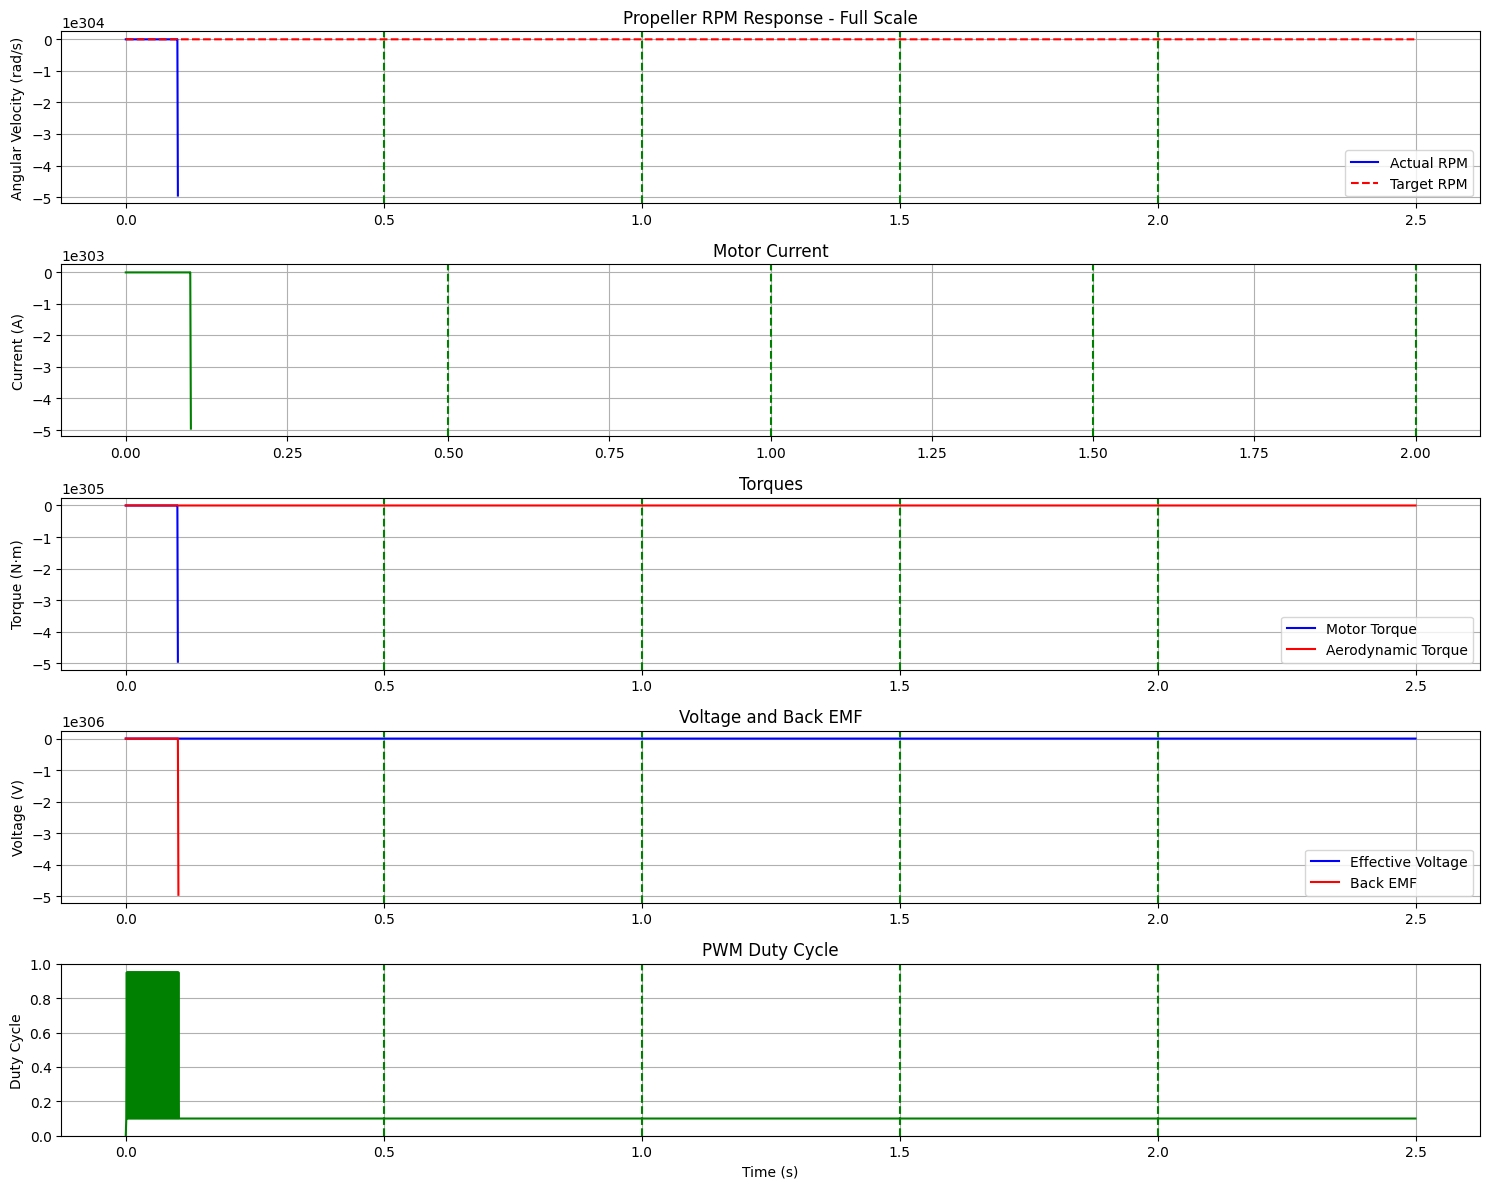

System Response at Key Times:
Time: 0.49s
  RPM: nan rad/s
  Current: nan A
  Q_aero: 0.0300 N·m
  Q_motor: nan N·m
  Voltage: 1.20 V
  Back EMF: nan V
  PWM Duty: 0.10

Time: 0.51s
  RPM: nan rad/s
  Current: nan A
  Q_aero: 0.1000 N·m
  Q_motor: nan N·m
  Voltage: 1.20 V
  Back EMF: nan V
  PWM Duty: 0.10

Time: 0.99s
  RPM: nan rad/s
  Current: nan A
  Q_aero: 0.1000 N·m
  Q_motor: nan N·m
  Voltage: 1.20 V
  Back EMF: nan V
  PWM Duty: 0.10

Time: 1.01s
  RPM: nan rad/s
  Current: nan A
  Q_aero: 0.0400 N·m
  Q_motor: nan N·m
  Voltage: 1.20 V
  Back EMF: nan V
  PWM Duty: 0.10

Time: 1.49s
  RPM: nan rad/s
  Current: nan A
  Q_aero: 0.0400 N·m
  Q_motor: nan N·m
  Voltage: 1.20 V
  Back EMF: nan V
  PWM Duty: 0.10

Time: 1.51s
  RPM: nan rad/s
  Current: nan A
  Q_aero: 0.1200 N·m
  Q_motor: nan N·m
  Voltage: 1.20 V
  Back EMF: nan V
  PWM Duty: 0.10

Time: 1.99s
  RPM: nan rad/s
  Current: nan A
  Q_aero: 0.1200 N·m
  Q_motor: nan N·m
  Voltage: 1.20 V
  Back EMF: nan V
  PWM Du

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# System parameters
J_rot = 0.01   # Rotational inertia (kg·m²)
L = 0.001      # Motor inductance (H)
R = 0.1        # Motor resistance (Ω)
K_Q = 0.01     # Motor torque constant (N·m/A)
K_v = 0.01     # Motor speed constant (V·s/rad)
i_0 = 0.5      # No-load current (A)
V_supply = 12.0  # Battery voltage (V)

# Simulation parameters
dt = 0.001     # Time step (s)
t_max = 2.5    # Simulation duration (s)

# Target RPM
target_rpm = 60.0  # rad/s

# Controller parameters
Kp = 1.2  # Proportional gain from your working version

# Create time array
t = np.arange(0, t_max, dt)
n_steps = len(t)

# Create arrays to store results
omega = np.zeros(n_steps)       # Angular velocity (rad/s)
current = np.zeros(n_steps)     # Motor current (A)
q_aero = np.zeros(n_steps)      # Aerodynamic torque (N·m)
q_motor = np.zeros(n_steps)     # Motor torque (N·m)
pwm_duty = np.zeros(n_steps)    # PWM duty cycle (0-1)
voltage = np.zeros(n_steps)     # Effective voltage (V)
back_emf = np.zeros(n_steps)    # Back EMF (V)

# Initial conditions
omega[0] = 60.0  # Start at target RPM
current[0] = 5.0  # Initial current (A)

# Define aerodynamic torque using your original function
def get_q_aero(time):
    if time < 0.5:
        return 0.03
    elif time < 1.0:
        return 0.10  # Larger step change
    elif time < 1.5:
        return 0.04
    elif time < 2.0:
        return 0.12  # Larger step change
    else:
        return 0.02

# Fill in the aerodynamic torque array
for i in range(n_steps):
    q_aero[i] = get_q_aero(t[i])

# Run simulation with electrical dynamics
for i in range(1, n_steps):
    # Calculate error
    error = target_rpm - omega[i-1]
    
    # Calculate PWM duty cycle (proportional control)
    pwm_duty[i] = min(max(0.1, Kp * error), 0.95)  # Limit between 10% and 95%
    
    # Calculate effective voltage from PWM
    voltage[i] = V_supply * pwm_duty[i]
    
    # Calculate back EMF
    back_emf[i] = omega[i-1] / K_v
    
    # Calculate current change (L * di/dt = v - v_back - i*R)
    di_dt = (voltage[i] - back_emf[i] - current[i-1] * R) / L
    
    # Update current
    current[i] = current[i-1] + di_dt * dt
    
    # Calculate motor torque
    q_motor[i] = (current[i] - i_0) / K_Q
    
    # Calculate acceleration
    alpha = (q_motor[i] - q_aero[i-1]) / J_rot
    
    # Update angular velocity
    omega[i] = omega[i-1] + alpha * dt

# Plot results
plt.figure(figsize=(15, 12))

# Angular velocity - full scale
plt.subplot(5, 1, 1)
plt.plot(t, omega, 'b-', label='Actual RPM')
plt.plot(t, np.ones_like(t) * target_rpm, 'r--', label='Target RPM')
plt.axvline(x=0.5, color='g', linestyle='--')
plt.axvline(x=1.0, color='g', linestyle='--')
plt.axvline(x=1.5, color='g', linestyle='--')
plt.axvline(x=2.0, color='g', linestyle='--')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Propeller RPM Response - Full Scale')
plt.grid(True)
plt.legend()

# Current
plt.subplot(5, 1, 2)
plt.plot(t, current, 'g-')
plt.axvline(x=0.5, color='g', linestyle='--')
plt.axvline(x=1.0, color='g', linestyle='--')
plt.axvline(x=1.5, color='g', linestyle='--')
plt.axvline(x=2.0, color='g', linestyle='--')
plt.ylabel('Current (A)')
plt.title('Motor Current')
plt.grid(True)

# Torques
plt.subplot(5, 1, 3)
plt.plot(t, q_motor, 'b-', label='Motor Torque')
plt.plot(t, q_aero, 'r-', label='Aerodynamic Torque')
plt.axvline(x=0.5, color='g', linestyle='--')
plt.axvline(x=1.0, color='g', linestyle='--')
plt.axvline(x=1.5, color='g', linestyle='--')
plt.axvline(x=2.0, color='g', linestyle='--')
plt.ylabel('Torque (N·m)')
plt.title('Torques')
plt.grid(True)
plt.legend()

# Voltage
plt.subplot(5, 1, 4)
plt.plot(t, voltage, 'b-', label='Effective Voltage')
plt.plot(t, back_emf, 'r-', label='Back EMF')
plt.axvline(x=0.5, color='g', linestyle='--')
plt.axvline(x=1.0, color='g', linestyle='--')
plt.axvline(x=1.5, color='g', linestyle='--')
plt.axvline(x=2.0, color='g', linestyle='--')
plt.ylabel('Voltage (V)')
plt.title('Voltage and Back EMF')
plt.grid(True)
plt.legend()

# PWM duty cycle
plt.subplot(5, 1, 5)
plt.plot(t, pwm_duty, 'g-')
plt.axvline(x=0.5, color='g', linestyle='--')
plt.axvline(x=1.0, color='g', linestyle='--')
plt.axvline(x=1.5, color='g', linestyle='--')
plt.axvline(x=2.0, color='g', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Duty Cycle')
plt.title('PWM Duty Cycle')
plt.ylim(0, 1)
plt.grid(True)

plt.tight_layout()
plt.show()

# Print key values at moments just before and after transitions
print("System Response at Key Times:")
for time in [0.49, 0.51, 0.99, 1.01, 1.49, 1.51, 1.99, 2.01]:
    # Find closest time index
    idx = np.abs(t - time).argmin()
    print(f"Time: {t[idx]:.2f}s")
    print(f"  RPM: {omega[idx]:.2f} rad/s")
    print(f"  Current: {current[idx]:.2f} A")
    print(f"  Q_aero: {q_aero[idx]:.4f} N·m")
    print(f"  Q_motor: {q_motor[idx]:.4f} N·m")
    print(f"  Voltage: {voltage[idx]:.2f} V")
    print(f"  Back EMF: {back_emf[idx]:.2f} V")
    print(f"  PWM Duty: {pwm_duty[idx]:.2f}")
    print()